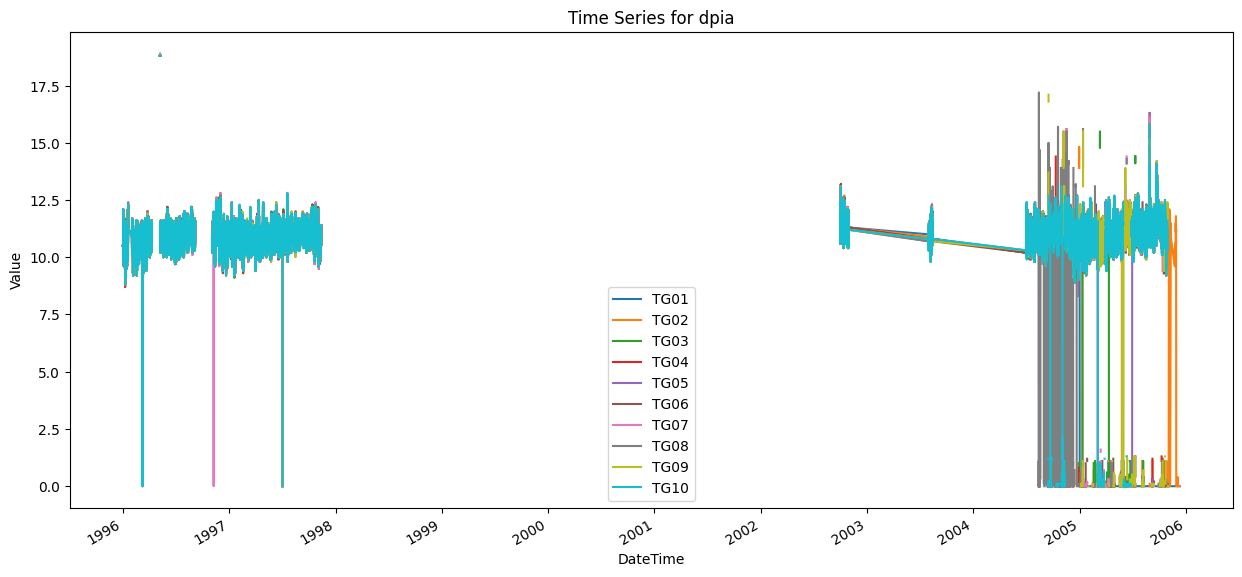

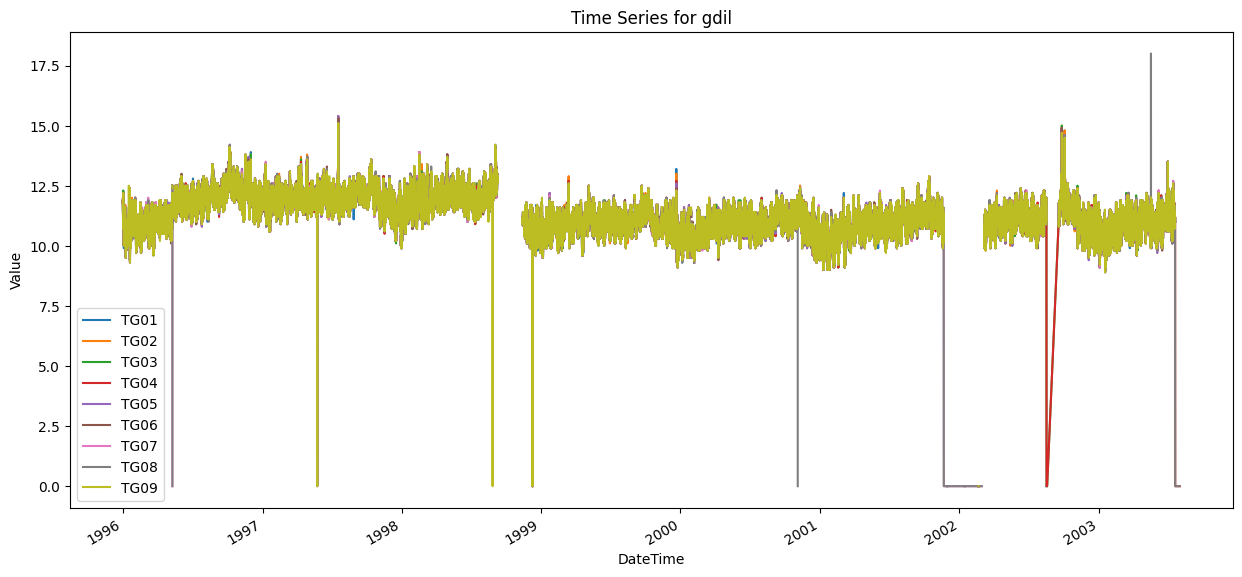

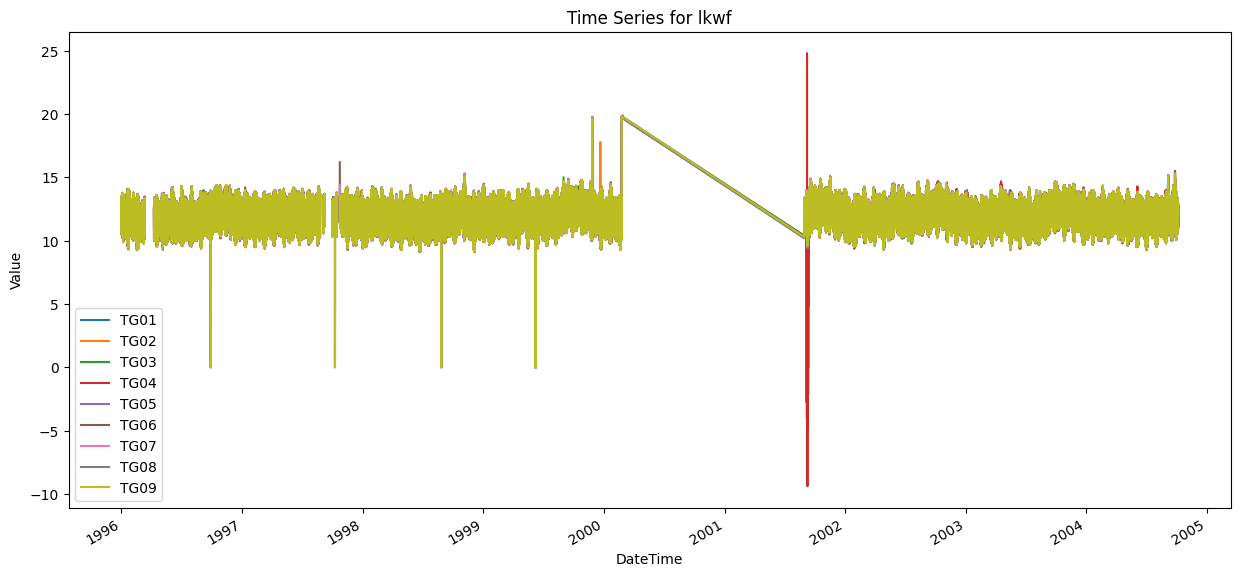

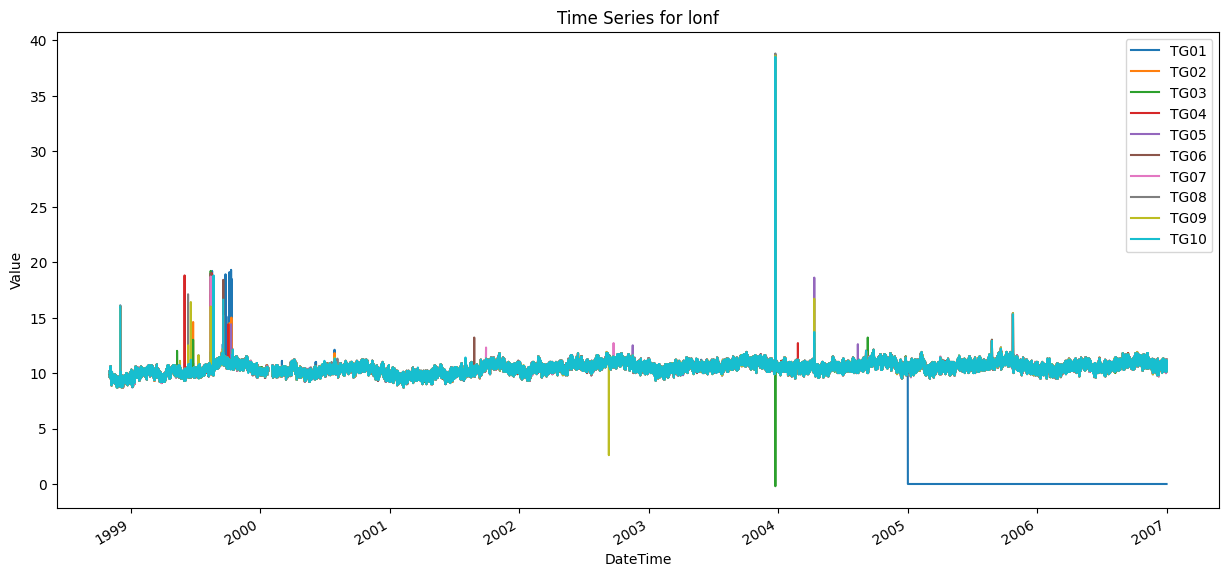

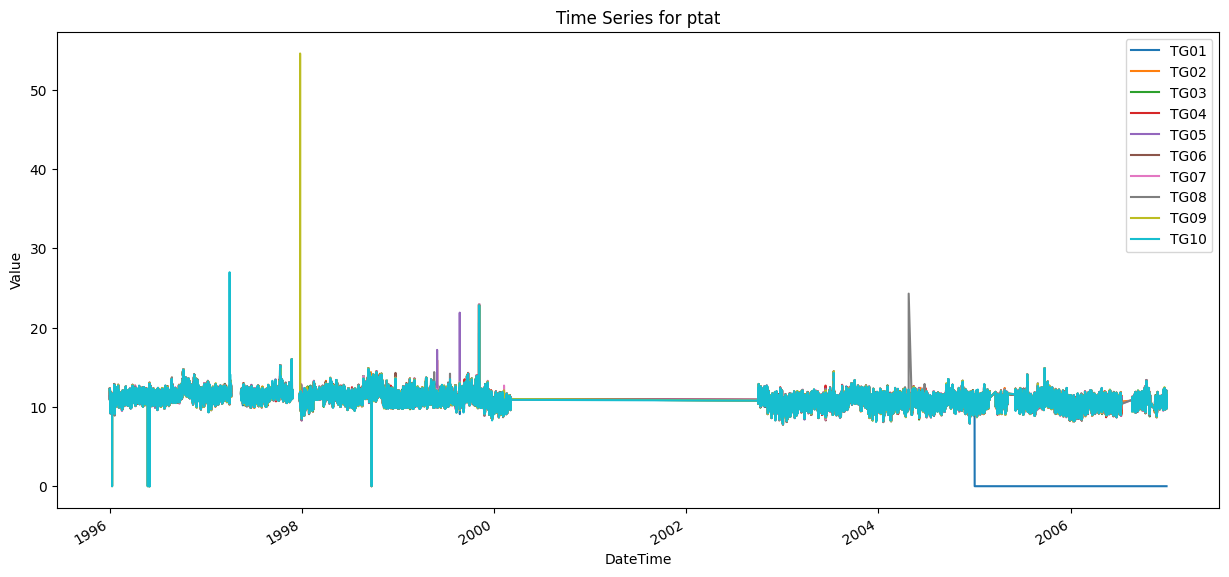

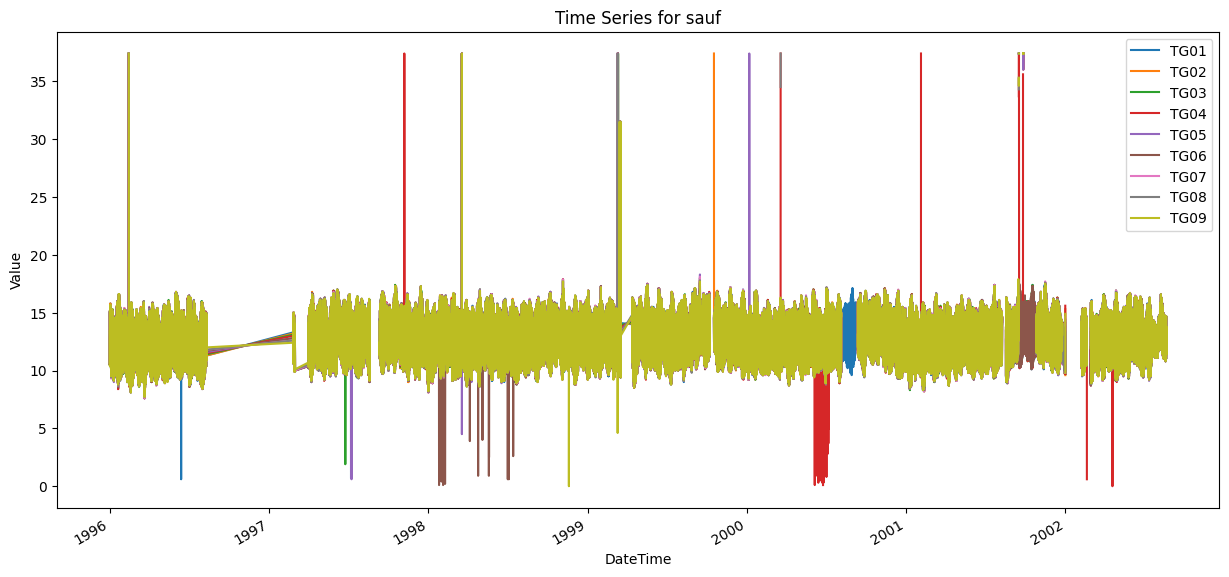

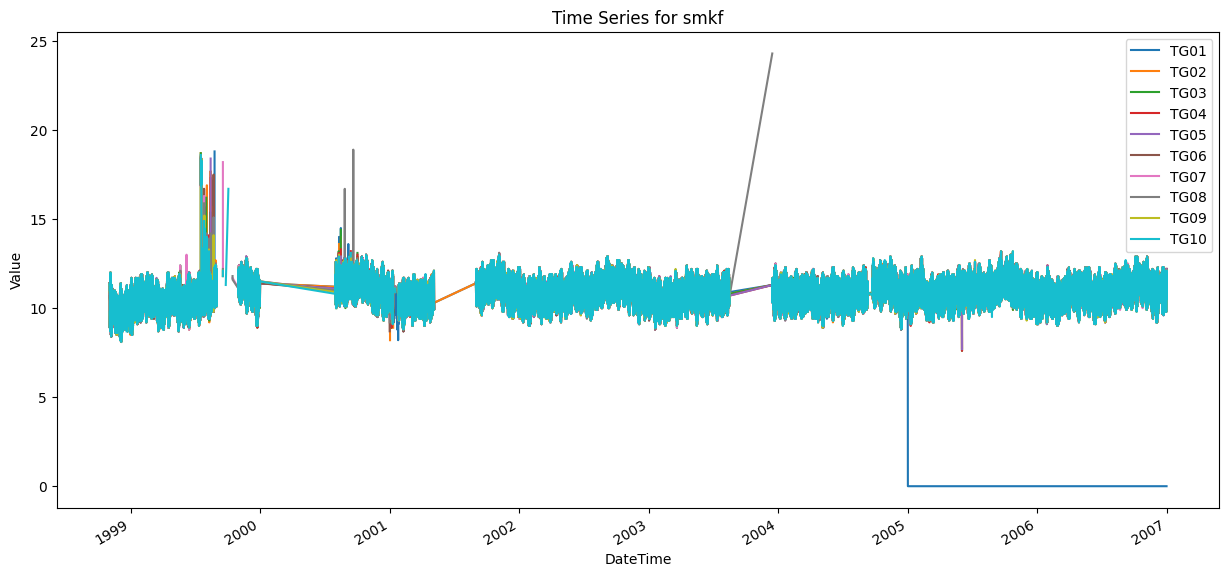

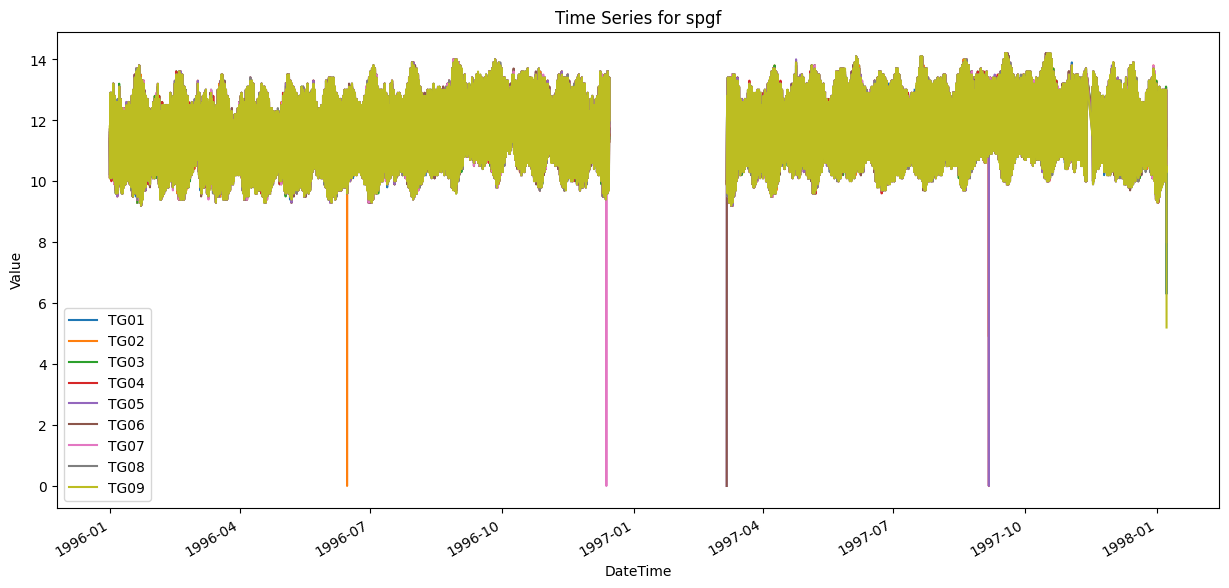

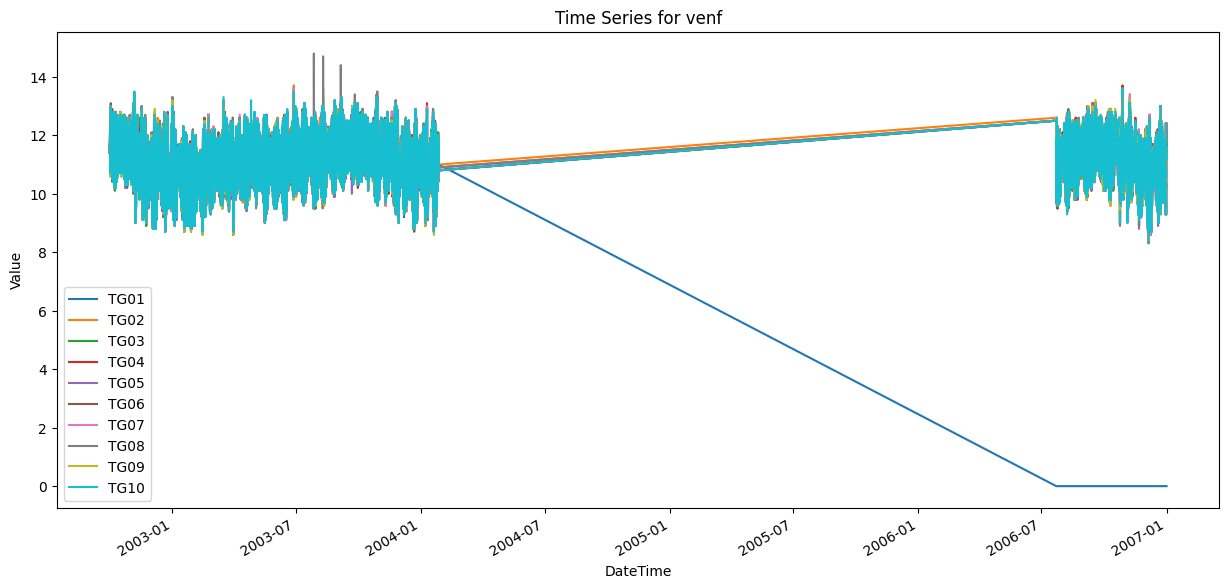

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np  # For using np.nan

data_dir = '/mnt/d/nbdc'

def read_and_preprocess(file_path):
    try:
        # Use skiprows to skip the header and infer the column names dynamically
        df = pd.read_csv(file_path, delim_whitespace=True, skiprows=1, header=None)
        with open(file_path, 'r') as f:
            first_line = f.readline()
        year_format = '%Y' if 'YYYY' in first_line else '%y'
        
        # Dynamically create column names based on the number of columns in the file
        num_columns = len(df.columns)
        column_names = ['Year', 'Month', 'Day', 'Hour'] + [f'TG{i:02d}' for i in range(1, num_columns-3)]
        df.columns = column_names
        
        # Replace 99.0 with np.nan for missing data
        df.replace(99.0, np.nan, inplace=True)
        
        # Create DateTime column and set it as index
        df['DateTime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']].astype(str).agg('-'.join, axis=1), format=f'{year_format}-%m-%d-%H', errors='coerce')
        return df.drop(['Year', 'Month', 'Day', 'Hour'], axis=1).set_index('DateTime')
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")
        return pd.DataFrame()

data_sources = {}

for filename in os.listdir(data_dir):
    if filename.endswith('.txt'):
        match = re.match(r"(\D+)[l\d]+\.txt", filename)
        if match:
            data_source = match.group(1)
            file_path = os.path.join(data_dir, filename)
            df = read_and_preprocess(file_path)
            if not df.empty:
                if data_source in data_sources:
                    data_sources[data_source] = pd.concat([data_sources[data_source], df])
                else:
                    data_sources[data_source] = df

# Plotting
for source, df in data_sources.items():
    plt.figure(figsize=(15, 7))
    for col in df.columns[:-1]:  # Exclude the 'DateTime' column from plotting
        df[col].plot(label=col)
    plt.title(f"Time Series for {source}")
    plt.legend()
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.show()
